# CS 8803 Mobile Manipulation Project: Obstacle Avoidance of Kinematically Redundant Manipulators


In [209]:
# pip install GTSAM to use the pose in SE(2)
!pip install gtsam

In [0]:
# pylint: disable=invalid-name, E1101

from __future__ import print_function

import math
import unittest
from functools import reduce
from ast import literal_eval

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # pylint: disable=W0611

import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import mpl_toolkits.mplot3d.axes3d as p3

# Required to do animations in colab
from matplotlib import animation
from IPython.display import HTML

import gtsam
import gtsam.utils.plot as gtsam_plot
from gtsam import Pose2

In [0]:
# Set plot parameters
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rc('animation', html='jshtml') # needed for animations!
arrowOptions = dict(head_width=.02,head_length=.02, width=0.01)

# Utility Funcions

In [0]:
# Some utility functions for Pose2
def vector7(a, b, c, d, e, f, g):
    """Create 7D double numpy array."""
    return np.array([a,b,c,d,e, f, g], dtype=np.float)

def compose(*poses):
    """Compose all Pose2 transforms given as arguments from left to right."""
    return reduce((lambda x, y: x.compose(y)), poses)

def delta(g0, g1):
    """Difference between x,y,,theta components of SE(2) poses."""
    return np.array([g1.x() - g0.x(), g1.y() - g0.y(), g1.theta() - g0.theta()])

def trajectory(g0, g1, N=20):
    """ Create an interpolated trajectory in SE(2), treating x,y, and theta separately.
        g0 and g1 are the initial and final pose, respectively.
        N is the number of *intervals*
        Returns N+1 poses
    """
    e = delta(g0, g1)
    spaced = np.linspace(0, 1, N)
    return [Pose2(g0.x()+e[0]*t, g0.y()+e[1]*t, g0.theta()+e[2]*t) for t in spaced ]

# Manipulator Class


In [0]:
# The 6-link manipulator class

class SixLinkArm(object):
    """6-link arm class."""

    def __init__(self):
        self.L1 = 2
        self.L2 = 2
        self.L3 = 2
        self.L4 = 2
        self.L5 = 2
        self.L6 = 2


    def fk(self, q):
        """ Forward kinematics.
            Takes numpy array of joint angles, in radians.
        """

        sXl1 = Pose2(0, 0, math.radians(90))
        l1Zl1 = Pose2(0, 0, q[0])
        l1Xl2 = Pose2(self.L1, 0, 0)
        sTl2 = compose(sXl1, l1Zl1, l1Xl2)

        l2Zl2 = Pose2(0, 0, q[1])
        l2Xl3 = Pose2(self.L2, 0, 0)
        sTl3 = compose(sTl2, l2Zl2, l2Xl3)

        l3Zl3 = Pose2(0, 0, q[2])
        l3Xl4 = Pose2(self.L3, 0, 0)
        sTl4 = compose(sTl3, l3Zl3, l3Xl4)

        l4Zl4 = Pose2(0, 0, q[3])
        l4Xl5 = Pose2(self.L4, 0, 0)
        sTl5 = compose(sTl4, l4Zl4, l4Xl5)

        l5Zl5 = Pose2(0, 0, q[4])
        l5Xl6 = Pose2(self.L5, 0, 0)
        sTl6 = compose(sTl5, l5Zl5, l5Xl6)
 
        l6Zl6 = Pose2(0, 0, q[5])
        l6Xt = Pose2(self.L6, 0, 0)
        sTt = compose(sTl6, l6Zl6, l6Xt)

        return sTt


    def jacobian(self, q):
        """ Calculate manipulator Jacobian.
            Takes numpy array of joint angles, in radians.
        """

        theta1 = q[0]
        alpha = q[0] + q[1]
        beta = q[0] + q[1] + q[2]
        gamma = q[0] + q[1] + q[2] + q[3]
        delta = q[0] + q[1] + q[2] + q[3] + q[4]
        kappa = q[0] + q[1] + q[2] + q[3] + q[4] + q[5]
        l1 = self.L1
        l2 = self.L2
        l3 = self.L3
        l4 = self.L4
        l5 = self.L5
        l6 = self.L6

        JM = np.array([[-l1*math.cos(theta1)- l2*math.cos(alpha) - l3*math.cos(beta) -l4*math.cos(gamma) - l5*math.cos(delta) - l6*math.cos(kappa),
                        -l2*math.cos(alpha) - l3*math.cos(beta) -l4*math.cos(gamma) - l5*math.cos(delta) - l6*math.cos(kappa),
                       - l3*math.cos(beta) -l4*math.cos(gamma) - l5*math.cos(delta) - l6*math.cos(kappa),
                        - l4*math.cos(gamma) - l5*math.cos(delta) - l6*math.cos(kappa),
                        - l5*math.cos(delta) - l6*math.cos(kappa), 
                        - l6*math.cos(kappa), 
                        0],
                       
                       [-l1*math.sin(theta1)- l2*math.sin(alpha) - l3*math.sin(beta) -l4*math.sin(gamma) - l5*math.sin(delta) - l6*math.sin(kappa),
                        - l2*math.sin(alpha) - l3*math.sin(beta) -l4*math.sin(gamma) - l5*math.sin(delta) - l6*math.sin(kappa), 
                        - l3*math.sin(beta) -l4*math.sin(gamma) - l5*math.sin(delta) - l6*math.sin(kappa), 
                        - l4*math.sin(gamma) - l5*math.sin(delta) - l6*math.sin(kappa),
                        - l5*math.sin(delta) - l6*math.sin(kappa), 
                        - l6*math.sin(kappa),  
                        0 ],
                       [1,1,1, 1, 1,1,1]])

        return JM


    def get_joint_positions(self, q):
        """ Returns the x and y coordinates of each joint.
            Takes numpy array of joint angles, in radians.
        """

        theta1 = q[0]
        alpha = q[0] + q[1]
        beta = q[0] + q[1] + q[2]
        gamma = q[0] + q[1] + q[2] + q[3]
        delta = q[0] + q[1] + q[2] + q[3] + q[4]
        kappa = q[0] + q[1] + q[2] + q[3] + q[4] + q[5]
        l1 = self.L1
        l2 = self.L2
        l3 = self.L3
        l4 = self.L4
        l5 = self.L5
        l6 = self.L6

        x_d = np.zeros((6))
        x_d[0] = l1*math.cos(theta1 + np.pi/2)
        x_d[1] = x_d[0] + l2*math.cos(alpha + np.pi/2)
        x_d[2] = x_d[1] + l3*math.cos(beta + np.pi/2)
        x_d[3] = x_d[2] + l4*math.cos(gamma + np.pi/2)
        x_d[4] = x_d[3] + l5*math.cos(delta + np.pi/2)
        x_d[5] = x_d[4] + l6*math.cos(kappa + np.pi/2)

        y_d = np.zeros((6))
        y_d[0] = l1*math.sin(theta1+ np.pi/2)
        y_d[1] = y_d[0] + l2*math.sin(alpha + np.pi/2)
        y_d[2] = y_d[1] + l3*math.sin(beta + np.pi/2)
        y_d[3] = y_d[2] + l4*math.sin(gamma + np.pi/2)
        y_d[4] = y_d[3] + l5*math.sin(delta + np.pi/2)
        y_d[5] = y_d[4] + l6*math.sin(kappa + np.pi/2)

        return x_d, y_d
        

    def first_task(self, x_d , y_d, mid_dist, dist, x_mid, y_mid):
        """ Calculate Jacobian and velocity of critical point.
            Takes the coordinates of joints, mid points of links, 
            distance of joints from obstacle and distance of mid 
            points from obstacle.
        """

        global centre_x
        global centre_y
        global diameter
        global q
      
        min_dist = np.min(dist)
        ind = np.argmin(dist)

        min_mid_dist = np.min(mid_dist)
        ind_m = np.argmin(mid_dist)

        threshold = 1.2

        if min_mid_dist < threshold*diameter or min_dist < threshold*diameter:
          
          if(min_mid_dist > min_dist):
            angle = np.degrees(np.arctan2((centre_y - y_d[ind]),(centre_x - x_d[ind])))
            print("Obstacle nearest to joint {}: {}".format(ind,angle))
            Jac = self.joint_mid_jacobian(ind, q, True)
            x_o, y_o = self.avoid_obstacle( angle)

          else:
            angle = np.degrees(np.arctan2((centre_y - y_mid[ind_m]),(centre_x - x_mid[ind_m])))
            print("Obstacle nearest to Mid {}: {} ".format(ind_m, angle))
            Jac = self.joint_mid_jacobian(ind_m, q, False)
            x_o, y_o = self.avoid_obstacle( angle)
         
        else: 
          Jac = np.zeros((3,7))
          x_o = 0
          y_o = 0

        return Jac, x_o, y_o

    def get_obstacle_distances(self, x_d, y_d):
        """ Calculate distance of joints and mid points of links from obstacle.
            Takes coordinates of joints.
        """
        global centre_x
        global centre_y

        x_mid = np.zeros((6))
        y_mid = np.zeros((6))
        mid_dist = np.zeros((6))

        dist = np.sqrt((x_d - centre_x)**2 + (y_d - centre_y)**2)

        for i in range(6):
          if i == 0:
            x_mid[i] = x_d[i]/2
            y_mid[i] = y_d[i]/2
            mid_dist[i] = np.sqrt((x_mid[i] - centre_x)**2 + (y_mid[i] - centre_y)**2)
          else:
            x_mid[i] = (x_d[i-1] + x_d[i])/2
            y_mid[i] = (y_d[i-1] + y_d[i])/2
            mid_dist[i] = np.sqrt((x_mid[i] - centre_x)**2 + (y_mid[i] - centre_y)**2)

        return dist, mid_dist, x_mid, y_mid


    def joint_mid_jacobian(self, ind, q, is_joint):
        """ Calculate critical point Jacobian.
            Takes index of joint or midpoint and joint angles.
        """

        theta1 = q[0]
        alpha = q[0] + q[1] 
        beta = q[0] + q[1] + q[2] 
        gamma = q[0] + q[1] + q[2] + q[3] 
        delta = q[0] + q[1] + q[2] + q[3] + q[4]
        kappa = q[0] + q[1] + q[2] + q[3] + q[4] + q[5]

        l1 = self.L1
        l2 = self.L2
        l3 = self.L3
        l4 = self.L4
        l5 = self.L5
        l6 = self.L6
        
        JM = np.zeros((3,7))

        c = np.zeros((6))
        c[0] = -l1*math.cos(theta1)
        c[1] = -l2*math.cos(alpha)
        c[2] = -l3*math.cos(beta)
        c[3] = -l4*math.cos(gamma)
        c[4] = -l5*math.cos(delta)
        c[5] = -l6*math.cos(kappa)

        s = np.zeros((6))
        s[0] = -l1*math.sin(theta1)
        s[1] = -l2*math.sin(alpha)
        s[2] = -l3*math.sin(beta)
        s[3] = -l4*math.sin(gamma)
        s[4] = -l5*math.sin(delta)
        s[5] = -l6*math.sin(kappa)

        for i in range(ind+1):
          JM[0,i] += np.sum(c[i: ind+1]) 
          JM[1,i] += np.sum(s[i: ind+1])
          JM[2,i] = 1

          if is_joint == False:
            JM[0,i] -= c[ind]/2
            JM[1,i] -= s[ind]/2

        return JM

    def avoid_obstacle(self, angle):
      """ Calculate velocity of critical point along opposite direction to the obstacle.
          Takes angle of critical point wrt obstacle.
      """

      global centre_x
      global centre_y
      global sTt_goal

      t = 0.2
      e = 180
      y_o = t*math.sin(np.radians((angle + e)%360 ))
      x_o = t*math.cos(np.radians((angle + e)%360 ))

      return x_o, y_o





In [0]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()

#Set up number of frames
frames = 100

size=10.5
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
omega = 2*math.pi/N

arm = SixLinkArm()

#Set initial joint angles
q = np.radians(vector7(60, 0, 0, -30, 0, -30, 30))

sTt_initial = arm.fk(q)

#Set goal Pose
sTt_goal = Pose2(2.5, -7.5, math.radians(0))
#Goal pose for failure scenario
# sTt_goal = Pose2(7.5, 5, math.radians(0))


#Get trajectory 
poses = trajectory(sTt_initial, sTt_goal, N)


centre_x = 0
centre_y = 0
diameter = 1

def init():
  rect = mpatches.Rectangle([0,0], 1, 1, angle =0)
  return (rect,)

end_effector_dist = []

# animation function. This is called sequentially  
def animate(i):
  global pose
  global arm
  global q
  global centre_x
  global centre_y
  global diameter
  global end_effector_dist

  print("Iteration : ", i)

  #Comment out your option

  #No obstacle condition
  # centre_x = 20
  # centre_y = 20

  #Mid stationary obstacle condition
  centre_x = 0
  centre_y = -2.5

  #Path stationary obstacle
  # centre_x = 2
  # centre_y = -5

  #Moving obstacle 
  # centre_x = -2.5 - i*0.06
  # centre_y = -5 + i*0.12

  #Moving obstacle with path blocking
  # centre_x = 7.5 - i*0.12
  # centre_y = -2.5 - i*0.12

  #Failure scenario. Change the goal pose as well. 
  # centre_x = 0
  # centre_y = 2.5

  #Find Term1, the task that avoids obstacles
  x_d, y_d = arm.get_joint_positions(q)
  dist, mid_dist, x_mid, y_mid = arm.get_obstacle_distances(x_d, y_d)
  J_o, x, y = arm.first_task(x_d, y_d, mid_dist, dist, x_mid, y_mid)   
  term1 = np.dot(np.linalg.pinv(J_o), np.array((x,y, 0)))
  q1 = term1
  
  #Get modified trajectory to goal pose after displacement by obstacle
  sTt = arm.fk(q + q1)
  dist = math.sqrt((sTt.x() - sTt_goal.x())**2 + (sTt.y() - sTt_goal.y())**2)
  end_effector_dist.append(dist)
  N = int(dist/0.5)
  poses = trajectory(sTt, sTt_goal, N)

  #Find Term2, the task for end-effector position tracking
  J_e = arm.jacobian(q)
  if len(poses) >2:
    error = delta(sTt, poses[1])
  else:
    error = delta(sTt, sTt_goal)
  term2 = np.dot(np.linalg.pinv(J_e), error)

  #Set alpha to increase or decrease weight of Task 1
  alpha = 0.5

  #Task2 is found in the Null space of task 1
  Null = np.eye(7) - alpha*np.dot(np.linalg.pinv(J_o), J_o)
  q2 = np.dot(Null, term2)
 
  #The final angles are the sum of angles resulting from both the tasks
  q += q1 + q2

  print("\n")

  # ------------------------- ANIMATION ----------------------------------------------------
  rect = rect = mpatches.Rectangle([-0.5,-0.5], 1, 1, angle =0)
  circle = mpatches.Circle([centre_x, centre_y], radius= diameter/2)
  
  ax.clear()
  ax.set_xlim((-size, size))
  ax.set_ylim((-size, size))
  ax.add_artist(rect)
  ax.add_artist(circle)
  
  ax.set_title("Frame {}".format(i))
  ax.scatter(sTt_goal.x(), sTt_goal.y(), color = 'red')
 
  sXl1 = Pose2(0, 0, math.radians(90))
  l1Zl1 = Pose2(0, 0, q[0])
  l1Xl2 = Pose2(arm.L1, 0, 0)
  sTl2 = compose(sXl1, l1Zl1, l1Xl2)
  t1 = sTl2.translation()
  ax.add_artist(mpatches.Rectangle([0,0], arm.L1, 0.1, angle =q[0]*180/np.pi+90, color='r'))

  l2Zl2 = Pose2(0, 0, q[1])
  l2Xl3 = Pose2(arm.L2, 0, 0)
  sTl3 = compose(sTl2, l2Zl2, l2Xl3)
  t2 = sTl3.translation()
  ax.add_artist(mpatches.Rectangle([t1.x(),t1.y()], arm.L2, 0.1, angle =(q[0]+q[1])*180/np.pi+90, color='g'))

  l3Zl3 = Pose2(0, 0, q[2])
  l3Xl4 = Pose2(arm.L3, 0, 0)
  sTl4 = compose(sTl3, l3Zl3, l3Xl4)
  t3 = sTl4.translation()
  ax.add_artist(mpatches.Rectangle([t2.x(),t2.y()], arm.L3, 0.1, angle =(q[0]+q[1] + q[2])*180/np.pi+90, color='y'))

  l4Zl4 = Pose2(0, 0, q[3])
  l4Xl5 = Pose2(arm.L4, 0, 0)
  sTl5 = compose(sTl4, l4Zl4, l4Xl5)
  t4 = sTl5.translation()
  ax.add_artist(mpatches.Rectangle([t3.x(),t3.y()], arm.L4, 0.1, angle =(q[0]+q[1] + q[2] + q[3])*180/np.pi+90, color='r'))

  l5Zl5 = Pose2(0, 0, q[4])
  l5Xl6 = Pose2(arm.L5, 0, 0)
  sTl6 = compose(sTl5, l5Zl5, l5Xl6)
  t5 = sTl6.translation()
  ax.add_artist(mpatches.Rectangle([t4.x(),t4.y()], arm.L5, 0.1, angle =(q[0]+q[1] + q[2] + q[3] + q[4])*180/np.pi+90, color='g'))

  l6Zl6 = Pose2(0, 0, q[5])
  l6Xt = Pose2(arm.L5, 0, 0)
  sTt = compose(sTl6, l6Zl6, l6Xt)
  t6 = sTt.translation()
  ax.add_artist(mpatches.Rectangle([t5.x(),t5.y()], arm.L6, 0.1, angle =(q[0]+q[1]+q[2] + q[3] + q[4] + q[5])*180/np.pi+90, color='b'))
  
#Uncomment to save file to mp4
# file = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=100, blit=False)

#Uncomment to view demo and plot in notebook
animation.FuncAnimation(fig, animate, init_func=init, frames= frames, interval=100, blit=False)

In [233]:
#Save mp4 file on system
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate= 1800)
name = 'stat_obstacle_alpha_0.5'
file.save('/content/' + name + '.mp4', writer = writer)

Iteration :  0


Iteration :  1


Iteration :  2


Iteration :  3


Iteration :  4


Iteration :  5


Iteration :  6


Iteration :  7


Iteration :  8


Iteration :  9


Iteration :  10


Iteration :  11


Iteration :  12


Iteration :  13


Iteration :  14


Iteration :  15


Iteration :  16


Iteration :  17


Iteration :  18


Iteration :  19


Iteration :  20


Iteration :  21


Iteration :  22
Obstacle nearest to joint 5: -42.98872781977938


Iteration :  23
Obstacle nearest to joint 5: -38.753758376411604


Iteration :  24
Obstacle nearest to joint 5: -33.398045404961366


Iteration :  25
Obstacle nearest to joint 5: -26.67081836147135


Iteration :  26
Obstacle nearest to joint 5: -18.375984519929897


Iteration :  27
Obstacle nearest to joint 5: -7.41468909600167


Iteration :  28
Obstacle nearest to joint 5: 5.2293470526736625


Iteration :  29
Obstacle nearest to joint 5: 18.579892784496465


Iteration :  30
Obstacle nearest to joint 5: 32.732876900906454


Iteration :  31
Ob

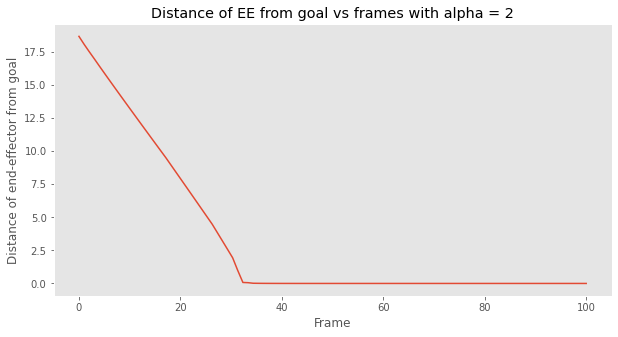

In [0]:
#Display plot Distance of EE from goal vs frames
plt.figure(figsize= (10,5))
plt.grid(b = None)
plt.plot( np.linspace(0, frames, frames), end_effector_dist)
plt.xlabel('Frame')
plt.ylabel('Distance of end-effector from goal')
plt.title('Distance of EE from goal vs frames')
plt.show()

In [234]:
#Convert mp4 file to .GIF

from moviepy.editor import *

name = 'stat_obstacle_alpha_0.5'
clip = (VideoFileClip("/content/" + name + ".mp4"))
clip.write_gif("/content/" + name + ".gif")


[MoviePy] Building file /content/stat_obstacle_alpha_0.5.gif with imageio


100%|██████████| 101/101 [00:03<00:00, 25.29it/s]


In [231]:
# Run this cell to evaluate multiple times and get quantitative evaluation  
def anim(an):
  global pose
  global arm
  global q
  global centre_x
  global centre_y
  global diameter
  global end_effector_dist
  global vel
  global frames
  global bumped

  #Find Term1, the task that avoids obstacles
  x_d, y_d = arm.get_joint_positions(q)
  dist, mid_dist, x_mid, y_mid = arm.get_obstacle_distances(x_d, y_d)
  J_o, x, y = arm.first_task(x_d, y_d, mid_dist, dist, x_mid, y_mid)   
  term1 = np.dot(np.linalg.pinv(J_o), np.array((x,y, 0)))
  q1 = term1
  
  #Get modified trajectory to goal pose after displacement by obstacle
  sTt = arm.fk(q + q1)
  dist1 = math.sqrt((sTt.x() - sTt_goal.x())**2 + (sTt.y() - sTt_goal.y())**2)
  end_effector_dist.append(dist1)
  N = int(dist1/vel)
  poses = trajectory(sTt, sTt_goal, N)

  #Find Term2, the task for end-effector position tracking
  J_e = arm.jacobian(q)
  if len(poses) >2:
    error = delta(sTt, poses[1])
  else:
    error = delta(sTt, sTt_goal)
  term2 = np.dot(np.linalg.pinv(J_e), error)

  #Set alpha to increase or decrease weight of Task 1
  alpha = 1.5

  #Task2 is found in the Null space of task 1
  Null = np.eye(7) - alpha*np.dot(np.linalg.pinv(J_o), J_o)
  q2 = np.dot(Null, term2)
 
  #The final angles are the sum of angles resulting from both the tasks
  q += q1 + q2

  sXl1 = Pose2(0, 0, math.radians(90))
  l1Zl1 = Pose2(0, 0, q[0])
  l1Xl2 = Pose2(arm.L1, 0, 0)
  sTl2 = compose(sXl1, l1Zl1, l1Xl2)
  t1 = sTl2.translation()

  l2Zl2 = Pose2(0, 0, q[1])
  l2Xl3 = Pose2(arm.L2, 0, 0)
  sTl3 = compose(sTl2, l2Zl2, l2Xl3)
  t2 = sTl3.translation()

  l3Zl3 = Pose2(0, 0, q[2])
  l3Xl4 = Pose2(arm.L3, 0, 0)
  sTl4 = compose(sTl3, l3Zl3, l3Xl4)
  t3 = sTl4.translation()

  l4Zl4 = Pose2(0, 0, q[3])
  l4Xl5 = Pose2(arm.L4, 0, 0)
  sTl5 = compose(sTl4, l4Zl4, l4Xl5)
  t4 = sTl5.translation()

  l5Zl5 = Pose2(0, 0, q[4])
  l5Xl6 = Pose2(arm.L5, 0, 0)
  sTl6 = compose(sTl5, l5Zl5, l5Xl6)
  t5 = sTl6.translation()

  l6Zl6 = Pose2(0, 0, q[5])
  l6Xt = Pose2(arm.L5, 0, 0)
  sTt = compose(sTl6, l6Zl6, l6Xt)
  t6 = sTt.translation()


  if np.min(dist) < diameter or np.min(mid_dist) < diameter:
    bumped = True

  reached_goal = False
  if an == frames - 1:
    reached_goal = math.sqrt((t6.x() - sTt_goal.x())**2 + (t6.y() - sTt_goal.y())**2) < 0.1
  return reached_goal
  
#Set number of frames and iterations here
iters = 5000
frames = 200


bumped_and_stopped = 0
bumped_didnt_stop = 0
didnt_bump_stopped = 0
didnt_bump_didnt_stop = 0

for it in range(iters):

  print("Iteration : ", it)
  reached_goal = False
  bumped = False

  arm = SixLinkArm()

  #Set initial joint angles
  random_angles = np.random.randint(-180, 180, size = (7,)  )
  q = np.radians(random_angles)

  sTt_initial = arm.fk(q)

  #Set goal Pose
  random_x = np.random.randint(-100, 100)
  random_y = np.random.randint(-100, 100)
  sTt_goal = Pose2(random_x/10, random_y/10, math.radians(0))

  centre_x = np.random.randint(-100, 100)/10
  centre_y = np.random.randint(-100, 100)/10
  diameter = 1

  vel = 0.5

  for an in range(frames):
    goal = anim(an)
    if goal:
      reached_goal = True

  if bumped== True and reached_goal == True:
    bumped_didnt_stop += 1
  elif bumped==True and reached_goal == False:
    bumped_and_stopped += 1
  elif bumped == False and reached_goal == False:
    didnt_bump_stopped += 1
  else:
    didnt_bump_didnt_stop += 1

print("Iteration {}\nDidn't bump, didn't stop {}\nDidn't bump but stopped {}\nBumped but didn't stop {}\n Bumped and stopped {}\n".format(
      it, didnt_bump_didnt_stop, didnt_bump_stopped, bumped_didnt_stop, bumped_and_stopped))


Streaming output truncated to the last 5000 lines.
Obstacle nearest to Mid 3: 92.42530529338632 
Obstacle nearest to Mid 3: 77.57009253826796 
Obstacle nearest to Mid 3: 92.12659456589797 
Obstacle nearest to Mid 3: 85.90592149529628 
Obstacle nearest to Mid 3: 78.32677831895288 
Obstacle nearest to Mid 3: 69.381553573402 
Obstacle nearest to Mid 3: 59.33340125575371 
Obstacle nearest to Mid 3: 41.15232802592159 
Iteration :  4480
Iteration :  4481
Iteration :  4482
Iteration :  4483
Iteration :  4484
Iteration :  4485
Iteration :  4486
Iteration :  4487
Iteration :  4488
Iteration :  4489
Obstacle nearest to joint 5: -62.99147553558044
Obstacle nearest to joint 5: -64.58383855578981
Obstacle nearest to joint 5: -58.72101093021271
Obstacle nearest to joint 5: -51.394168836008156
Obstacle nearest to joint 5: -42.50348889059513
Obstacle nearest to joint 5: -32.81810315100319
Obstacle nearest to joint 5: -22.590722164881356
Obstacle nearest to joint 5: -10.564556203838963
Obstacle nearest